In [1]:
import torch
import torch.nn as nn
from math import pi #to get the definition of pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This is a thermal problem.

In [2]:
k = 400 #thermal conductivity of copper
stefanBoltz = 5.670373e-8 # stefan-boltzman cst
h = 1 #plate size
Tb = 1000 #temperature of the bottom
epsilon=0.5 # emissivity
rho = 8960 # Copper density
Cp=386 #specific heat
Ta = 300 #ambient temperature
tz = 0.01 # plate thickness

#for ease of use
a = rho*Cp*tz
b = -k*tz
c = 2*h
d = 2*stefanBoltz*epsilon

In [160]:
n = 25
L=h
#bottom edge
rand_L = np.random.rand(n) * L 
discr_s1 = (np.array([rand_L.transpose(), np.zeros(n)])).transpose()

#other edges
border = np.ones([n])*L
rand_L = np.random.rand(n) * L 
discr_s2_1 = np.array([border, rand_L.transpose()]).transpose()
rand_L = np.random.rand(n) * L 
discr_s2_2 = np.array([rand_L.transpose(), border]).transpose()
rand_L = np.random.rand(n) * L 
discr_s2_3 = np.array([np.zeros(n), rand_L.transpose()]).transpose()

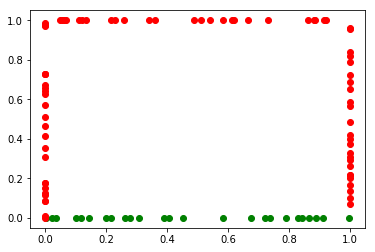

In [161]:
plt.plot(discr_s1[:,0],discr_s1[:,1], 'go')
plt.plot(discr_s2_1[:,0],discr_s2_1[:,1],'ro') 
plt.plot(discr_s2_2[:,0],discr_s2_2[:,1],'ro') 
plt.plot(discr_s2_3[:,0],discr_s2_3[:,1],'ro') 

In [162]:
n=200
discr_om = np.array([np.random.rand(n), np.random.rand(n)]).transpose() * L
discr_om = discr_om[np.where((np.abs(discr_om[:,0])< L-0.02))]
discr_om = discr_om[np.where((np.abs(discr_om[:,1])< L-0.02))]
discr_om = discr_om[np.where((np.abs(discr_om[:,0])> 0.02))]
discr_om = discr_om[np.where((np.abs(discr_om[:,1])> 0.02))]

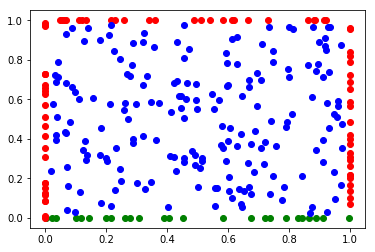

In [163]:
plt.plot(discr_s1[:,0],discr_s1[:,1], 'go')
plt.plot(discr_s2_1[:,0],discr_s2_1[:,1],'ro') 
plt.plot(discr_s2_2[:,0],discr_s2_2[:,1],'ro') 
plt.plot(discr_s2_3[:,0],discr_s2_3[:,1],'ro') 
plt.plot(discr_om[:,0],discr_om[:,1],'bo')

In [164]:
discr_t = np.linspace(0.1,200,20)

In [165]:
size_om = discr_om.shape[0]
size_s1 = discr_s1.shape[0]
size_s2 = discr_s2_1.shape[0]

discr_om_t = np.concatenate((discr_om, np.ones([size_om,1])*discr_t[0]), axis=1)
discr_s1_t = np.concatenate((discr_s1, np.ones([size_s1,1])*discr_t[0]), axis=1)
discr_s2_1_t = np.concatenate((discr_s2_1, np.ones([size_s2,1])*discr_t[0]), axis=1)
discr_s2_2_t = np.concatenate((discr_s2_2, np.ones([size_s2,1])*discr_t[0]), axis=1)
discr_s2_3_t = np.concatenate((discr_s2_3, np.ones([size_s2,1])*discr_t[0]), axis=1)
discr_om_0 = np.concatenate((discr_om, np.ones([size_om,1])*0), axis=1)
for i in range(discr_t.size - 1 ):
    discr_om_t_temp = np.concatenate((discr_om, np.ones([size_om,1])*discr_t[i+1]), axis=1)
    discr_om_t = np.concatenate((discr_om_t, discr_om_t_temp))
    
    discr_s1_t_temp = np.concatenate((discr_s1, np.ones([size_s1,1])*discr_t[i+1]), axis=1)
    discr_s1_t = np.concatenate((discr_s1_t, discr_s1_t_temp))
    
    discr_s2_t_temp = np.concatenate((discr_s2_1, np.ones([size_s2,1])*discr_t[i+1]), axis=1)
    discr_s2_1_t = np.concatenate((discr_s2_1_t, discr_s2_t_temp))
    
    discr_s2_t_temp = np.concatenate((discr_s2_1, np.ones([size_s2,1])*discr_t[i+1]), axis=1)
    discr_s2_2_t = np.concatenate((discr_s2_2_t, discr_s2_t_temp))
    
    discr_s2_t_temp = np.concatenate((discr_s2_3, np.ones([size_s2,1])*discr_t[i+1]), axis=1)
    discr_s2_3_t = np.concatenate((discr_s2_3_t, discr_s2_t_temp))
    
discr_s2_t = np.concatenate((discr_s2_1_t,discr_s2_2_t,discr_s2_3_t))

print(discr_om_t.shape,discr_s1_t.shape,discr_s2_t.shape, discr_om_0.shape)


discr_om_t = torch.tensor(discr_om_t, requires_grad=True).to(torch.float32).cuda()
discr_s1_t = torch.tensor(discr_s1_t, requires_grad=True).to(torch.float32).cuda()
discr_s2_t = torch.tensor(discr_s2_t, requires_grad=True).to(torch.float32).cuda()
discr_om_0 = torch.tensor(discr_om_0, requires_grad=True).to(torch.float32).cuda()

data = torch.cat((discr_om_0, discr_om_t, discr_s1_t, discr_s2_t)); 
size_om_t,size_s1, size_s2,size_om_0 = discr_om_t.shape[0],discr_s1_t.shape[0],discr_s2_t.shape[0], discr_om_0.shape[0]

(3780, 3) (500, 3) (1500, 3) (189, 3)


In [166]:
def g1(X) : return 0 #no conductivity on s2
def g2(X) : return 1000 #temperature at the bottom
def u0(X) : return 300 #initial temperature of the plate
def f(X) : return 0 #left hand side of the PDE

In [167]:
def Loss_test1(discr_om_t, discr_s1_t, discr_s2_t, discr_om) :

    #compute solution
    N_om = model(discr_om_t)[:,0] # For the PDE
    N_s1 = model(discr_s1_t) # for the BC on sigma1
    N_s2 = model(discr_s2_t)[:,0] # for the BC on sigma2
    N_0 = model(discr_om)[:,0] # for the BC on omega at t=0
    
    #derivative on the domain
    fst_order = torch.autograd.grad(N_om.sum(), discr_om_t, create_graph=True)
    hes_x = torch.autograd.grad(fst_order[0][:,0].sum(),discr_om_t, create_graph=True)[0][:,0]
    hes_y = torch.autograd.grad(fst_order[0][:,1].sum(),discr_om_t, create_graph=True)[0][:,1]
    
    #derivative on the top and side edges
    fst_order_s2 = torch.autograd.grad(N_s2.sum(), discr_s2_t, create_graph=True)
    normal_derivative = torch.cat((fst_order_s2[0][:400,0],fst_order_s2[0][400:800,1], -fst_order_s2[0][800:,0]))
    
    
    loss_om = torch.sum((a*fst_order[0][:,2] + b*(hes_x + hes_y) + c*(N_om-Ta) + d*(N_om**4-Ta**4))**2)
    loss_s1 = torch.sum((N_s1-Tb)**2)
    loss_s2 = torch.sum((normal_derivative)**2)
    loss_0  = torch.sum((N_0-Ta)**2)
    
    loss =   torch.sqrt(loss_s1) + torch.sqrt(loss_om) + torch.sqrt(loss_s2) + torch.sqrt(loss_0.sum())
    
    return loss
    
    

In [168]:
def Loss_test2(data,size_om_0, size_om_t,size_s1, size_s2) :
    #data order is the same as size order.
    output = model(data)
    
    #data slice
    om_0 = slice(0, size_om_0)
    om_t = slice(size_om_0, size_om_0+size_om_t)
    s1_t = slice(size_om_0+size_om_t, size_om_0+size_om_t+size_s1)
    s2_t = slice(size_om_0+size_om_t+size_s1, size_om_0+size_om_t+size_s1+size_s2)
    
    fst_order = torch.autograd.grad(N_om.sum(), data, create_graph=True)
    hes_x = torch.autograd.grad(fst_order[0][om_t,0].sum(),data[om_t], create_graph=True)[0][:,0]
    hes_y = torch.autograd.grad(fst_order[0][om_t,1].sum(),data[om_t], create_graph=True)[0][:,1]
    
    normal= torch.where((data[:,0]==0) |(data[:,0]==1), fst_order, 0)
    
    normal_derivative = torch.cat((fst_order_s2[0][:25,0],fst_order_s2[0][25:50,1], -fst_order_s2[0][50:,0]))

    

In [194]:
class DGM(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.S1 = nn.Linear(3,50)
        self.Z1 = nn.Linear(50,50) ; self.UZ1 = nn.Linear(3,50, bias=False)
        self.G1 = nn.Linear(50,50) ; self.UG1 = nn.Linear(3,50, bias=False)
        self.R1 = nn.Linear(50,50) ; self.UR1 = nn.Linear(3,50, bias=False)
        self.H1 = nn.Linear(50,50) ; self.UH1 = nn.Linear(3,50, bias=False)

        self.Z2 = nn.Linear(50,50) ; self.UZ2 = nn.Linear(3,50, bias=False)
        self.G2 = nn.Linear(50,50) ; self.UG2 = nn.Linear(3,50, bias=False)
        self.R2 = nn.Linear(50,50) ; self.UR2 = nn.Linear(3,50, bias=False)
        self.H2 = nn.Linear(50,50) ; self.UH2 = nn.Linear(3,50, bias=False)

        self.Z3 = nn.Linear(50,50) ; self.UZ3 = nn.Linear(3,50, bias=False)
        self.G3 = nn.Linear(50,50) ; self.UG3 = nn.Linear(3,50, bias=False)
        self.R3 = nn.Linear(50,50) ; self.UR3 = nn.Linear(3,50, bias=False)
        self.H3 = nn.Linear(50,50) ; self.UH3 = nn.Linear(3,50, bias=False)
        self.S4 = nn.Linear(50,50)
        self.Z4 = nn.Linear(50,50) ; self.UZ4 = nn.Linear(3,50, bias=False)
        self.G4 = nn.Linear(50,50) ; self.UG4 = nn.Linear(3,50, bias=False)
        self.R4 = nn.Linear(50,50) ; self.UR4 = nn.Linear(3,50, bias=False)
        self.H4 = nn.Linear(50,50) ; self.UH4 = nn.Linear(3,50, bias=False)

        self.f = nn.Linear(50,1)
        
        self.bn1 = nn.BatchNorm1d(50)
        self.bn2 = nn.BatchNorm1d(50)
        self.bn3 = nn.BatchNorm1d(50)
        
    def forward(self,x):
        s1 = torch.relu(self.S1(x))
        z1 = torch.tanh(self.UZ1(x)+self.Z1(s1))
        g1 = torch.tanh(self.UG1(x)+self.G1(s1))
        r1 = torch.tanh(self.UR1(x)+self.R1(s1))
        h1 = torch.tanh(self.UH1(x)+self.H1(s1*r1))
        s2 = (1 - g1) * h1 + z1*s1 + s1
        z2 = torch.tanh(self.UZ2(x)+self.Z2(s2))
        g2 = torch.tanh(self.UG2(x)+self.G2(s2))
        r2 = torch.tanh(self.UR2(x)+self.R2(s2))
        h2 = torch.tanh(self.UH2(x)+self.H2(s2*r2))
        s3 = (1 - g2) * h2 + z2*s2 + s2
        z3 = torch.tanh(self.UZ3(x)+self.Z3(s3))
        g3 = torch.tanh(self.UG3(x)+self.G3(s3))
        r3 = torch.tanh(self.UR3(x)+self.R3(s3))
        h3 = torch.tanh(self.UH3(x)+self.H3(s3*r3))
        s4 = (1 - g3) * h3 + z3*s3 +s3
        x = self.f(s4)
        return x

In [195]:
class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 100, bias=True) #multipliyin the input by some weigth
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 100)
        self.linear4 = nn.Linear(100, 1)

        self.bn1 = nn.BatchNorm1d(100)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(100)
        
    def forward(self,x):
        x = torch.tanh(self.bn1(self.linear1(x)))
        x = torch.tanh(self.bn2(self.linear2(x))) + x
        x = torch.tanh(self.bn3(self.linear3(x))) + x
        x = self.linear4(x)

        return x

In [196]:
model = DGM() #the network we created
opt = torch.optim.Adam(model.parameters(),lr = 0.01) #gradient descent
model.cuda()

def fit_final(epochs, lr=0.001):
    opt.param_groups[0]['lr'] = lr
    
    for epoch in range(epochs):
        epoch +=1
        opt.zero_grad()
        loss =Loss_test1(discr_om_t, discr_s1_t, discr_s2_t, discr_om_0) 
        loss.backward()
        opt.step()# update the parameters
        if epoch % (epochs//10) == 0: print('epoch {}, loss {}'.format(epoch, loss.data))

In [197]:
lr = [5e-1,1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4,5e-5,1e-5,5e-6,1e-6,5e-7,1e-7]


In [206]:
fit_final(100,0.00001)

epoch 10, loss 30020.322265625
epoch 20, loss 30020.322265625
epoch 30, loss 30020.322265625
epoch 40, loss 30020.322265625
epoch 50, loss 30020.322265625
epoch 60, loss 30020.322265625
epoch 70, loss 30020.322265625
epoch 80, loss 30020.322265625
epoch 90, loss 30020.322265625
epoch 100, loss 30020.322265625


In [207]:

#compute solution
N_om = model(discr_om_t)[:,0] # For the PDE
N_s1 = model(discr_s1_t)[:,0] # for the BC on sigma1
N_s2 = model(discr_s2_t)[:,0] # for the BC on sigma2
N_0 = model(discr_om_0)[:,0] # for the BC on omega at t=0
    
#derivative on the domain
fst_order = torch.autograd.grad(N_om.sum(), discr_om_t, create_graph=True)
hes_x = torch.autograd.grad(fst_order[0][:,0].sum(),discr_om_t, create_graph=True)[0][:,0]
hes_y = torch.autograd.grad(fst_order[0][:,1].sum(),discr_om_t, create_graph=True)[0][:,1]
   
#derivative on the top and side edges
fst_order_s2 = torch.autograd.grad(N_s2.sum(), discr_s2_t, create_graph=True)
normal_derivative = torch.cat((fst_order_s2[0][:25,0],fst_order_s2[0][25:50,1], -fst_order_s2[0][50:,0]))
    
    
loss_om = (a*fst_order[0][:,2] - b*(hes_x + hes_y) + c*(N_om-Ta) + d*(N_om**4-Ta**4))**2
loss_s1 = (N_s1-Tb)**2
loss_s2 = (normal_derivative)**2
loss_0  = (N_0-Ta)**2

In [208]:
N_s1

tensor([ 59.0602,  59.0548,  59.0593,  59.0623,  59.0546,  59.0534,  59.0544,
         59.0560,  59.0562,  59.0635,  59.0626,  59.0536,  59.0554,  59.0607,
         59.0614,  59.0573,  59.0575,  59.0579,  59.0537,  59.0618,  59.0621,
         59.0565,  59.0555,  59.0619,  59.0608, -61.7748, -61.7802, -61.7757,
        -61.7727, -61.7805, -61.7816, -61.7807, -61.7790, -61.7789, -61.7716,
        -61.7724, -61.7815, -61.7796, -61.7743, -61.7736, -61.7777, -61.7775,
        -61.7771, -61.7813, -61.7733, -61.7729, -61.7785, -61.7795, -61.7731,
        -61.7742, -61.4207, -61.4261, -61.4216, -61.4185, -61.4263, -61.4275,
        -61.4265, -61.4249, -61.4247, -61.4174, -61.4183, -61.4273, -61.4255,
        -61.4202, -61.4195, -61.4236, -61.4234, -61.4229, -61.4272, -61.4191,
        -61.4188, -61.4244, -61.4254, -61.4190, -61.4200, -61.0666, -61.0719,
        -61.0675, -61.0644, -61.0722, -61.0734, -61.0724, -61.0707, -61.0706,
        -61.0633, -61.0641, -61.0732, -61.0714, -61.0661, -61.06

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

s = 101
data = pd.read_csv('Laplacian100.csv', header=None) #let's import a grid
X = np.concatenate((data.values[:,0:2], np.ones([data.shape[0],1])*5000 ), axis=1)
X = torch.tensor(X, requires_grad=True).to(torch.float32).cuda();X

x = np.reshape(data.values[:,0],[s,s])
y = np.reshape(data.values[:,1],[s,s])

N = model(X).cpu()
u_model = np.reshape(N.data.numpy(),[s,s])

plt.contour(x,y,u_model)

In [ ]:
#data order is the same as size order.
output = model(data)
    
#data slice
om_0 = slice(0, size_om_0)
om_t = slice(size_om_0, size_om_0+size_om_t)
s1_t = slice(size_om_0+size_om_t, size_om_0+size_om_t+size_s1)
s2_t = slice(size_om_0+size_om_t+size_s1, size_om_0+size_om_t+size_s1+size_s2)
    
fst_order = torch.autograd.grad(output.sum(), data, create_graph=True)
hes_x = torch.autograd.grad(fst_order[0][om_t,0].sum(),data[om_t], create_graph=True)[0][:,0]
hes_y = torch.autograd.grad(fst_order[0][om_t,1].sum(),data[om_t], create_graph=True)[0][:,1]
    
normal= torch.where((data[:,0]==0) |(data[:,0]==1), fst_order, 0)
    
normal_derivative = torch.cat((fst_order_s2[0][:25,0],fst_order_s2[0][25:50,1], -fst_order_s2[0][50:,0]))

In [18]:
model.S1.weight

Parameter containing:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
   